Time Series
======

Time series is a domain that exemplifies:

* Use of the past as a feature to predict the present
* Markov assumptions
* Time averaging

Problems:

* Past artifacts
* Variable length features
* Smart normalization (history == larger pool for normalization)


Example Data
-------------

We will be using a [2015 dump of carbon emissions from the province of British Columbia, Canada](https://catalogue.data.gov.bc.ca/dataset/british-columbia-greenhouse-gas-emissions-archive). It is distributed as two CSV files.

In [1]:
import numpy as np

extra = np.loadtxt("bcghgrelateddata1990-2013pub2015.csv", delimiter=",", skiprows=1)
years = extra[:,0]
year2pos = { str(int(year)): idx for idx, year in enumerate(list(years)) }
emissions = np.zeros((len(years),),dtype='float32')

with open("bcghgemissions1990-2013pub2015.csv") as csv:
    header = None
    for line in csv:
        cols = line[0:-1].split(",")
        if header is None:
            header = cols
        else:
            for idx, title in enumerate(header):
                if title in year2pos:
                    try:
                        value = float(cols[idx])
                    except: # cringe
                        value = 0
                    emissions[year2pos[title]] += value
print(header)
print(emissions[:10])
population = extra[:,2]
print(population)
gdp = extra[:,4]
print(gdp)  

['sector', 'subsector_level1', 'subsector_level2', 'subsector_level3', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
[-3557.0825 -4280.162   2239.4707  2759.7803 10159.93   21229.094
 12559.875   6672.5273 19191.863  12730.901 ]
[3292111. 3373787. 3468802. 3567772. 3676075. 3777390. 3874317. 3948583.
 3983113. 4011375. 4039230. 4076881. 4100161. 4123937. 4155017. 4195764.
 4241691. 4290988. 4349412. 4410679. 4465924. 4499139. 4542508. 4582625.]
[120153. 120424. 123754. 129522. 133172. 136607. 140114. 144305. 146112.
 150649. 157515. 158509. 164116. 168011. 174591. 183235. 191101. 197072.
 199270. 194214. 200628. 206225. 211124. 215218.]


Text(0.5,1,'gdp')

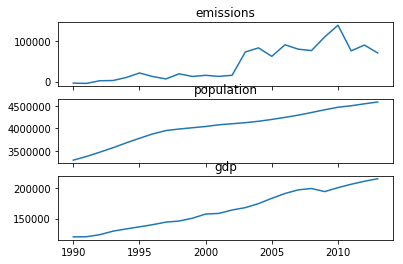

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(nrows=3, sharex=True)
axs[0].plot(years, emissions)
axs[1].plot(years, population)
axs[2].plot(years, gdp)
axs[0].set_title("emissions")
axs[1].set_title("population")
axs[2].set_title("gdp")

From the graphs we can see that changes in population result in delayed changes in carbon emissions (maybe). And changes in carbon emissions may affect GDP.

This is very little data so we will use year up to 2005 as training, 2005-2010 as devtest and 2010-2013 as final test.

Our first model won't incorporate any time data, just a non-linear regression using population and gdp as features.

In [3]:
train_years = list(map(int, filter(lambda x:x < 2005, years)))
test_years =  list(map(int, filter(lambda x:2005 <= x and x < 2010, years)))
final_test_years =  list(map(int, filter(lambda x:2010 <= x, years)))

print("Train years: ", len(train_years))
print("Devtest years: ", len(test_years))
print("Test years: ", len(final_test_years))

xtrain = np.zeros((len(train_years), 2), dtype='float32')
ytrain = np.zeros((len(train_years),), dtype='float32')
xtest = np.zeros((len(test_years), 2), dtype='float32')
ytest = np.zeros((len(test_years),), dtype='float32')

for idx, year in enumerate(train_years):
    pos = year2pos[str(year)]
    xtrain[idx][0] = population[pos]
    xtrain[idx][1] = gdp[pos]
    ytrain[idx] = emissions[pos]

for idx, year in enumerate(test_years):
    pos = year2pos[str(year)]
    xtest[idx][0] = population[pos]
    xtest[idx][1] = gdp[pos]
    ytest[idx] = emissions[pos]

Train years:  15
Devtest years:  5
Test years:  4


In [11]:
# normalization is key to this problem

# this is the original (wrong) normalization using xtrain instead of ytrain
# I'm leaving it here as the text comments refer to those results
# how can this normalization be obtained from ytrain needs more digging

# scaling_emissions_min = xtrain.min()
# scaling_emissions_max = xtrain.max()
scaling_emissions_min = ytrain.min()
scaling_emissions_max = ytrain.max()
scaling_emissions = 1.0 / (scaling_emissions_max - scaling_emissions_min)
    
scaling_emissions_mean = ytrain.mean()
scaling_emissions_stddev = ytrain.std()
scaling_emissions = 1.0 / scaling_emissions_stddev

ytrain_scaled = np.copy(ytrain)
# ytrain_scaled -= scaling_emissions_min
ytrain_scaled -= scaling_emissions_mean
ytrain_scaled *= scaling_emissions

ytest_scaled = np.copy(ytest)
# ytest_scaled -= scaling_emissions_min
ytest_scaled -= scaling_emissions_mean
ytest_scaled *= scaling_emissions

scaling_population_min = xtrain[:,0].min()
scaling_population_max = xtrain[:,0].max()
scaling_population = 1.0 / (scaling_population_max - scaling_population_min)

scaling_gdp_min = xtrain[:,1].min()
scaling_gdp_max = xtrain[:,1].max()
scaling_gdp = 1.0 / (scaling_gdp_max - scaling_gdp_min)

xtrain_scaled = np.copy(xtrain)
xtrain_scaled[:,0] -= scaling_population_min
xtrain_scaled[:,0] *= scaling_population
xtrain_scaled[:,1] -= scaling_gdp_min
xtrain_scaled[:,1] *= scaling_gdp


xtest_scaled = np.copy(xtest)
xtest_scaled[:,0] -= scaling_population_min
xtest_scaled[:,0] *= scaling_population
xtest_scaled[:,1] -= scaling_gdp_min
xtest_scaled[:,1] *= scaling_gdp

epsilon = 0.001

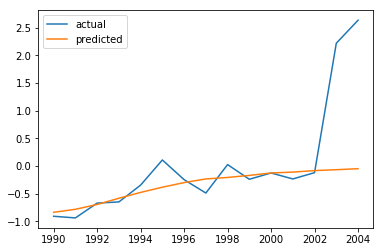

In [12]:
from sklearn.svm import SVR

svr_rbf = SVR(epsilon=epsilon)
svr_rbf.fit(xtrain_scaled, ytrain_scaled)
ytrain_pred = svr_rbf.predict(xtrain_scaled)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years, ytrain_scaled, label="actual")
plt.plot(train_years, ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.9255030027276364
RMSE on test  2.7951693673108227


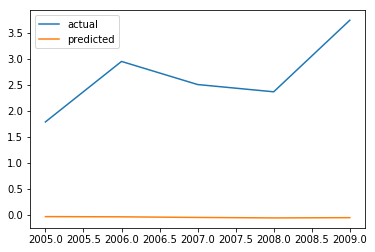

In [13]:
from sklearn.metrics import mean_squared_error
import math

ytest_pred = svr_rbf.predict(xtest_scaled)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_scaled, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

Markov assumption
--------------------

A key assumption dealing with time series is that the underlining process has limited "memory", that is, it depends only on a limited number of previous states. Such processes are called Markov processes and the number of previous states needed to predict them are called the _order_ of the Markov process.

When doing feature engineering for time series, the Markov assumption can be used two fold: incorporating the real value (or class) from previous times and incorporating the value of the _features_ for previous times (_lag features_).

We will look at both approaches in turn over our running example.

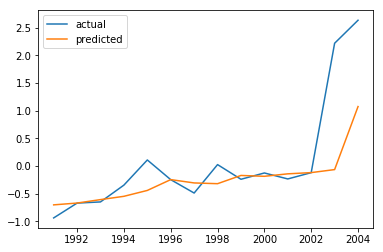

In [14]:
# drop first year as there is no data
xtrain_order_1 = np.zeros((len(train_years)-1, 3), dtype='float32') 
xtrain_order_1[:,:-1] = xtrain_scaled[1:,:]
for i in range(1,len(train_years)):
    xtrain_order_1[i - 1][2] = ytrain_scaled[i - 1]
ytrain_order_1 = np.zeros((len(train_years)-1,))
ytrain_order_1[:] = ytrain_scaled[1:]

# no need to drop a year on test
xtest_order_1 = np.zeros((len(test_years), 3), dtype='float32')
xtest_order_1[:,:-1] = xtest_scaled
xtest_order_1[0][2] = ytrain_scaled[-1]
for i in range(1,len(test_years)):
    xtest_order_1[i][2] = ytest_scaled[i - 1]

svr_rbf = SVR(epsilon=epsilon)
svr_rbf.fit(xtrain_order_1, ytrain_order_1)
ytrain_pred = svr_rbf.predict(xtrain_order_1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[1:], ytrain_order_1, label="actual")
plt.plot(train_years[1:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.7658597149338295
RMSE on test  1.7899578849232638


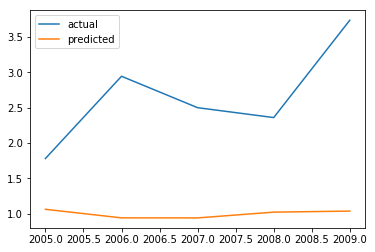

In [15]:
ytest_pred = svr_rbf.predict(xtest_order_1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_order_1, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

Thus, adding a Markov feature of order 1 increases the error on training but reduces the error on test: it generalizes better. Let's try an order 2 now.

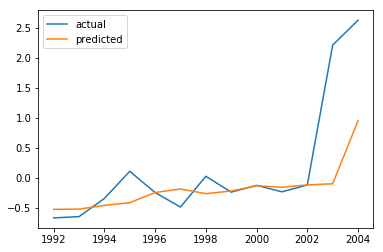

In [16]:
# drop another year as there is no data
xtrain_order_2 = np.zeros((len(train_years) - 2, 4), dtype='float32') 
xtrain_order_2[:,:-1] = xtrain_order_1[1:,:]
for i in range(2, len(train_years)):
    xtrain_order_2[i - 2][3] = ytrain_scaled[i - 2]
ytrain_order_2 = np.zeros((len(train_years) - 2,))
ytrain_order_2[:] = ytrain_scaled[2:]

# no need to drop a year on test
xtest_order_2 = np.zeros((len(test_years), 4), dtype='float32')
xtest_order_2[:,:-1] = xtest_order_1
xtest_order_2[0][3] = ytrain_scaled[-2]
xtest_order_2[1][3] = ytrain_scaled[-1]
for i in range(2, len(test_years)):
    xtest_order_2[i][3] = ytest_scaled[i - 2]

svr_rbf = SVR(epsilon=epsilon)
svr_rbf.fit(xtrain_order_2, ytrain_order_2)
ytrain_pred = svr_rbf.predict(xtrain_order_2)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[2:], ytrain_order_2, label="actual")
plt.plot(train_years[2:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.8181480341972455
RMSE on test  2.4074162693966565


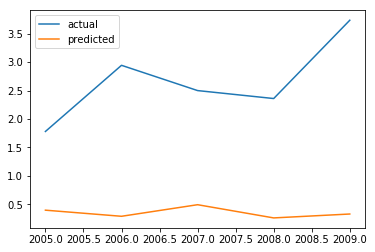

In [17]:
ytest_pred = svr_rbf.predict(xtest_order_2)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_order_2, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

Order 2 keeps generalizing better. Trying other orders might be worth looking into, but it might start to overfit. We turn our attention now to lag features, that is, instead of incorporating the value for a previous time, we incorporate the features for the previous time.

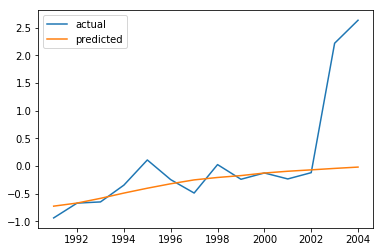

In [18]:
# drop first year as there is no data
xtrain_lag_1 = np.zeros((len(train_years)-1, 4), dtype='float32') 
xtrain_lag_1[:,:-2] = xtrain_scaled[1:,:]
xtrain_lag_1[:,-2:] = xtrain_scaled[:-1,:]
ytrain_lag_1 = np.zeros((len(train_years)-1,))
ytrain_lag_1[:] = ytrain_scaled[1:]

# no need to drop a year on test
xtest_lag_1 = np.zeros((len(test_years), 4), dtype='float32')
xtest_lag_1[:,:-2] = xtest_scaled
xtest_lag_1[0,-2:] = xtrain_scaled[-1,:]
xtest_lag_1[1:,-2:] = xtest_scaled[:-1,:]

svr_rbf = SVR(epsilon=epsilon)
svr_rbf.fit(xtrain_lag_1, ytrain_lag_1)
ytrain_pred = svr_rbf.predict(xtrain_lag_1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[1:], ytrain_lag_1, label="actual")
plt.plot(train_years[1:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.9495038710131782
RMSE on test  2.740858777254723


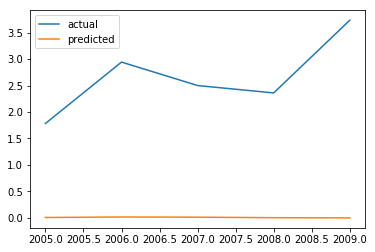

In [19]:
ytest_pred = svr_rbf.predict(xtest_lag_1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_lag_1, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

Sliding windows
-----------------

Finally, another approach is to take the average of the features over a window before the current time. We will use a window of size 3.

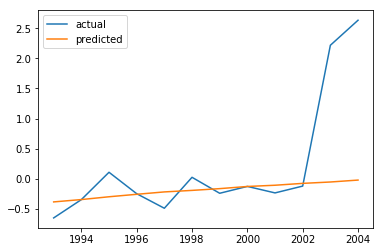

In [20]:
# drop first three year as there is no data
xtrain_win_3 = np.zeros((len(train_years)-3, 4), dtype='float32') 
xtrain_win_3[:,:-2] = xtrain_scaled[3:,:]
population_sliding_avg = xtrain_scaled[0:3,0].sum() / 3.0
gdp_sliding_avg = xtrain_scaled[0:3,1].sum() / 3.0
xtrain_win_3[0,2] = population_sliding_avg
xtrain_win_3[0,3] = gdp_sliding_avg

for idx in range(1, len(train_years) - 3):
    if idx < 3:
        population_sliding_avg -= xtrain_scaled[idx-1,0] / 3.0
        gdp_sliding_avg -= xtrain_scaled[idx-1,1] / 3.0
    else:
        population_sliding_avg -= xtrain_win_3[idx-3,0] / 3.0
        gdp_sliding_avg -= xtrain_win_3[idx-3,1] / 3.0
    population_sliding_avg += xtrain_win_3[idx,0] / 3.0
    gdp_sliding_avg += xtrain_win_3[idx,1] / 3.0
    xtrain_win_3[idx, 2] = population_sliding_avg
    xtrain_win_3[idx, 3] = gdp_sliding_avg

ytrain_win_3 = np.zeros((len(train_years)-3,))
ytrain_win_3[:] = ytrain_scaled[3:]

# no need to drop years on test
xtest_win_3 = np.zeros((len(test_years), 4), dtype='float32')
xtest_win_3[:,:-2] = xtest_scaled
population_sliding_avg = xtrain_scaled[-3:,0].sum() / 3.0
gdp_sliding_avg = xtrain_scaled[-3:,1].sum() / 3.0
xtest_win_3[0,2] = population_sliding_avg
xtest_win_3[0,3] = gdp_sliding_avg
for idx in range(1, len(test_years)):
    if idx < 3:
        population_sliding_avg -= xtrain_scaled[len(train_years) - 3 + idx,0] / 3.0
        gdp_sliding_avg -= xtrain_scaled[len(train_years) - 3 + idx,1] / 3.0
    else:
        population_sliding_avg -= xtest_win_3[idx-3,0] / 3.0
        gdp_sliding_avg -= xtest_win_3[idx-3,1] / 3.0
    population_sliding_avg += xtest_win_3[idx,0] / 3.0
    gdp_sliding_avg += xtest_win_3[idx,1] / 3.0
    xtest_win_3[idx, 2] = population_sliding_avg
    xtest_win_3[idx, 3] = gdp_sliding_avg

svr_rbf = SVR(epsilon=epsilon)
svr_rbf.fit(xtrain_win_3, ytrain_win_3)
ytrain_pred = svr_rbf.predict(xtrain_win_3)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[3:], ytrain_win_3, label="actual")
plt.plot(train_years[3:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 1.0237835204613914
RMSE on test  2.6985623498992566


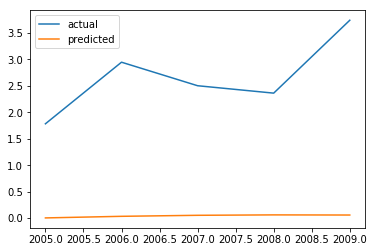

In [21]:
ytest_pred = svr_rbf.predict(xtest_win_3)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_win_3, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

Not as bad as lag 1 but not as good as Markov order 2. Combining all the approaches might yield the best results.

Convolution
-------------

Computing the average over the window is just a particular type of convolution kernel. Other kernels are possible. Here we explore generating an indicator feature that outputs 1.0 if the change between the last two emissions increased by more than 10%.


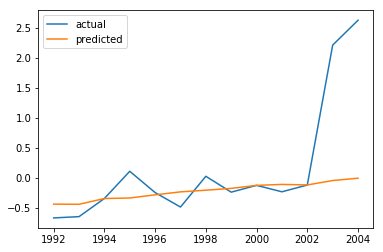

In [22]:
# this is an order 2 feature
xtrain_convo = np.zeros((len(train_years) - 2, 3), dtype='float32') 
xtrain_convo[:,:-1] = xtrain_order_2[:,:-2]
for idx in range(0,len(train_years) - 2):
    xtrain_convo[idx][2] = 1.0 if (xtrain_order_2[idx][3] - xtrain_order_2[idx][2]) / xtrain_order_2[idx][3] > 0.1 else 0.0 
ytrain_convo = ytrain_order_2
ytrain_order_1[:] = ytrain_scaled[1:]

# no need to drop a year on test
xtest_convo = np.zeros((len(test_years), 3), dtype='float32')
xtest_convo[:,:-1] = xtest_order_2[:,:-2]
for idx in range(0,len(test_years)):
    xtest_convo[idx][2] = 1.0 if (xtest_order_2[idx][3] - xtest_order_2[idx][2]) /  xtest_order_2[idx][3] > 0.1 else 0.0 

svr_rbf = SVR(epsilon=epsilon)
svr_rbf.fit(xtrain_convo, ytrain_convo)
ytrain_pred = svr_rbf.predict(xtrain_convo)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[2:], ytrain_convo, label="actual")
plt.plot(train_years[2:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.9815885794474094
RMSE on test  2.740113465091078


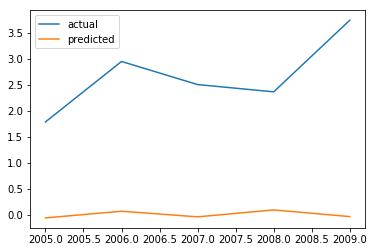

In [23]:
ytest_pred = svr_rbf.predict(xtest_convo)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_convo, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

Wow. Didn't expect that.

# PRACTICO START HERE!

## Hipótesis

- Asumo como modelo conservador el SVR utilizado.
- Voy a probar como modelo optimo un [RandomForestRegresor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Mi intuicion me dice que al ser la poblacion un valor discreto, los arboles pueden generalizar mejor.
- Voy a empezar a probar las iteraciones nuevamente desde con loa **Marcov-Features Order 2** que es donde funcionaba mejor.
- Luego voy a pasar los features por un histograma para tratar de generalizar mas el RadomForest
  
## Marcov Order 2

Mejora

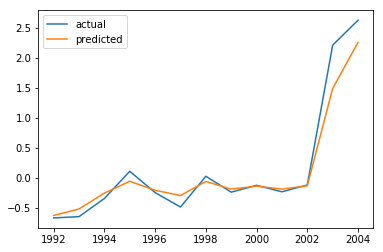

In [68]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(xtrain_order_2, ytrain_order_2)
ytrain_pred = rfr.predict(xtrain_order_2)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[2:], ytrain_order_2, label="actual")
plt.plot(train_years[2:], ytrain_pred, label="predicted")
plt.legend()


RMSE on train 0.24264935290400472
RMSE on test  0.7661653751338768


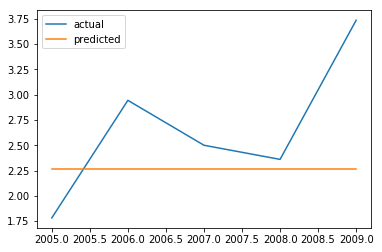

In [69]:
ytest_pred = rfr.predict(xtest_order_2)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_order_2, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

## LAG 

**Empeora**

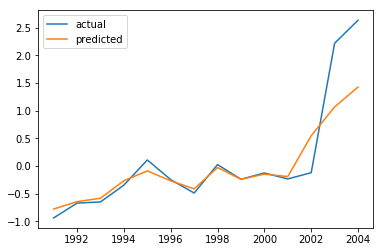

In [73]:
rfr = RandomForestRegressor()
rfr.fit(xtrain_lag_1, ytrain_lag_1)
ytrain_pred = rfr.predict(xtrain_lag_1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[1:], ytrain_lag_1, label="actual")
plt.plot(train_years[1:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.4864674488172081
RMSE on test  1.400630682968861


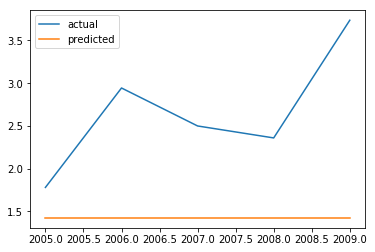

In [74]:
ytest_pred = rfr.predict(xtest_lag_1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_lag_1, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

## Sliding Windows

**Mejora pero no tanto como marcov order 2**

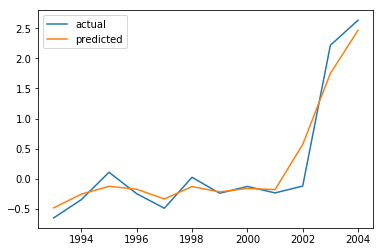

In [76]:
rfr = RandomForestRegressor()
rfr.fit(xtrain_win_3, ytrain_win_3)
ytrain_pred = rfr.predict(xtrain_win_3)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[3:], ytrain_win_3, label="actual")
plt.plot(train_years[3:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.2693552588935081
RMSE on test  0.6817032223644245


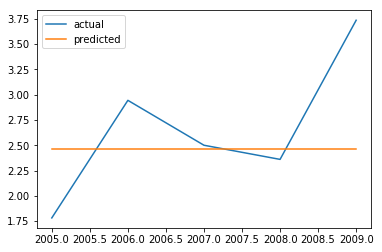

In [77]:
ytest_pred = rfr.predict(xtest_win_3)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_win_3, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))

## Conversion a histogramas

El mejor resultado lo logro con 11 bins, casi la cantidad de valores que tiene el array original. La solución empeora

In [162]:
def histogramize(values, bins):
    hist = np.histogram(values, bins=bins)[-1]
    bins = []
    for e in values:
        bin = 0
        for idx in range(len(hist)):
            if hist[idx-1] <= e < hist[idx]:
                bin = idx
                break    
        bins.append(bin)
    return np.array(bins)

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 1, 1, 2],
       [3, 2, 1, 2],
       [3, 2, 2, 3],
       [4, 3, 2, 0],
       [4, 3, 1, 4],
       [4, 3, 2, 3],
       [5, 4, 2, 5],
       [5, 4, 2, 4],
       [5, 4, 2, 4],
       [5, 5, 2, 4],
       [0, 0, 0, 4]])

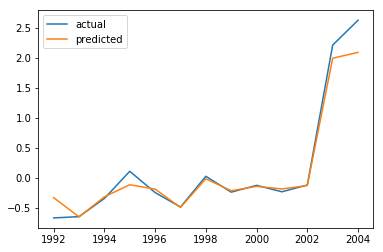

In [187]:
from sklearn.ensemble import RandomForestRegressor

xtrain_hist = np.apply_along_axis(histogramize, axis=0, arr=xtrain_order_2, bins=11)

rfr = RandomForestRegressor()
rfr.fit(xtrain_hist, ytrain_order_2)
ytrain_pred = rfr.predict(xtrain_hist)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_years[2:], ytrain_order_2, label="actual")
plt.plot(train_years[2:], ytrain_pred, label="predicted")
plt.legend()

RMSE on train 0.1981601647280205
RMSE on test  2.552326171050844


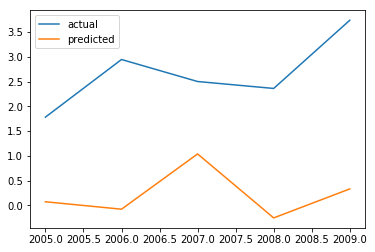

In [188]:
xtrain_hist = np.apply_along_axis(histogramize, axis=0, arr=xtest_order_2, bins=11)

ytest_pred = rfr.predict(xtest_hist)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_years, ytest_scaled, label="actual")
plt.plot(test_years, ytest_pred, label="predicted")
plt.legend()

print("RMSE on train", math.sqrt(mean_squared_error(ytrain_order_2, ytrain_pred)))
print("RMSE on test ", math.sqrt(mean_squared_error(ytest_scaled, ytest_pred)))